The assignment was done with a lot of research, group study and consultation with the instructors. 

The code was adapted from Lab on GANs and VAE. Other used references are being attached below: 

1. https://towardsdatascience.com/gans-vs-autoencoders-comparison-of-deep-generative-models-985cf15936ea

2. https://medium.com/lis-computer-vision-blogs/gans-cgans-ae-aae-ave-caae-cave-2e7d23255b52

3. https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/

4. https://github.com/qbxlvnf11/conditional-GAN

5. https://medium.com/analytics-vidhya/step-by-step-implementation-of-conditional-generative-adversarial-networks-54e4b47497d6

6. https://github.com/timbmg/VAE-CVAE-MNIST

7. https://medium.com/analytics-vidhya/step-by-step-implementation-of-conditional-generative-adversarial-networks-54e4b47497d6



# Assignment 3


In this assignment, you will convert GAN and VAE implementations into Conditional GAN and Conditional VAE, respectively: 

Grading:
- Conditional GAN (35 points):
  - Data preprocessing (10 points)
  - Discriminator and Generator (15 points)
  - Training (10 points)
- Conditional VAE (35 points):
  - Data preprocessing (10 points)
  - Encoder and Decoder (15 points)
  - Training (10 points)
- Comparison (15 points):
  - Conditional GAN image generation (5 points)
  - Conditional VAE image generation (5 points)
  - Your opinion which results are better (5 points)
- Metrics and training plots (10 points)
- Clean and documented code (5 points)


Remarks: 

*   Use Fashion MNIST dataset
*   Use Pytorch
*   Cheating will result in 0 points

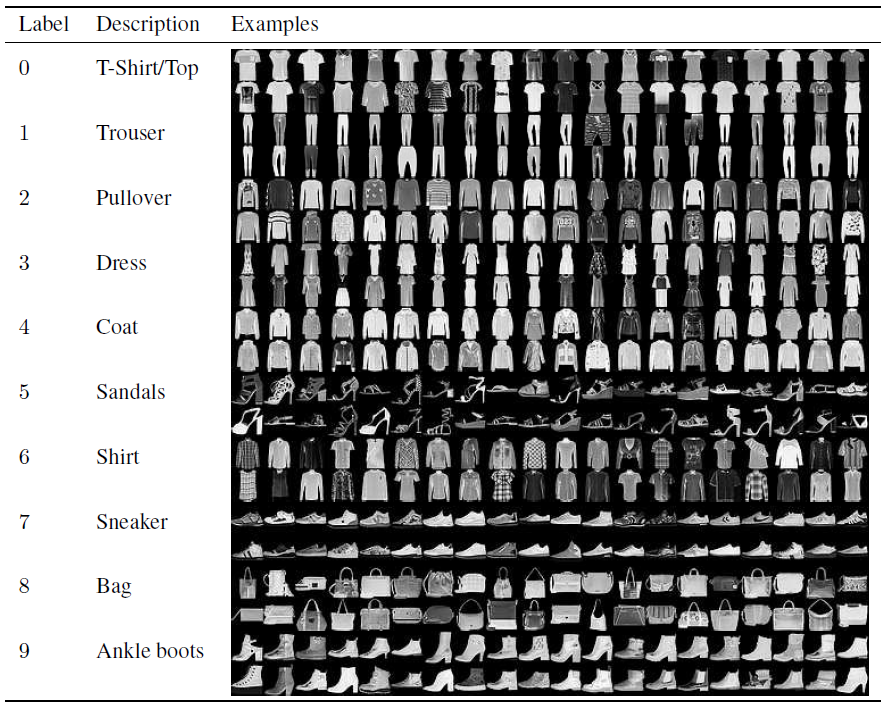

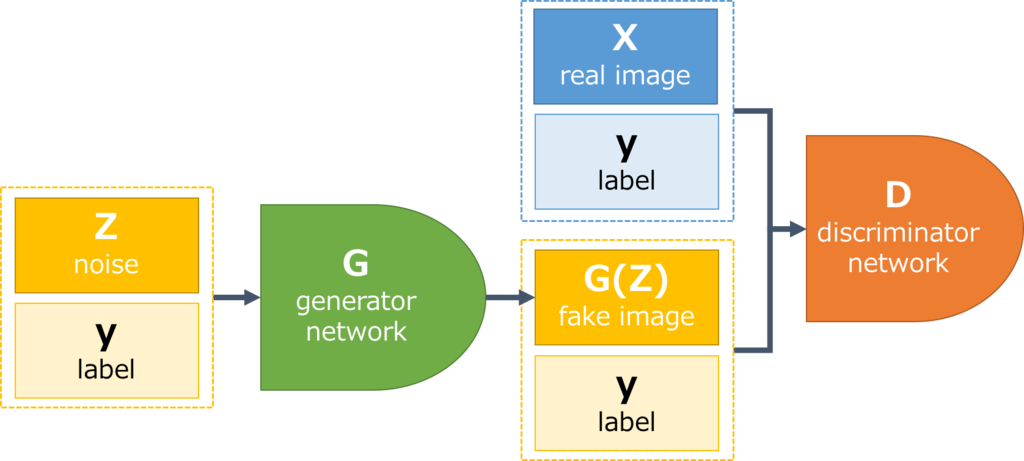

# Conditional GAN
Change this GAN implementation from Lab 11 into Conditional GAN

## Data
Use Fashion MNIST dataset

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



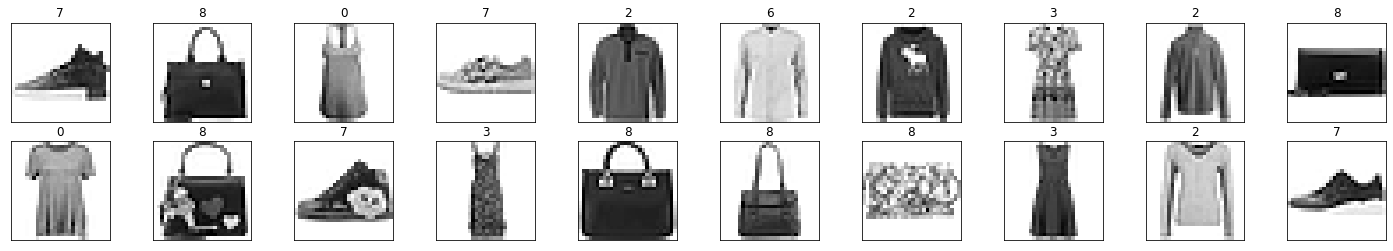

In [1]:
# importing important libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from torchvision.utils import make_grid
from torch.autograd import Variable
import torch
from torchvision import datasets
from torchvision import transforms

# convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
transform = transforms.ToTensor()

# creating train set, we do this by downloding the data with train parameter as true 
FMNIST_train = datasets.FashionMNIST(root='data/', train=True, download=True, transform=transform)

# creating test set, we do this by downloading the data with train parameter as false
FMNIST_test = datasets.FashionMNIST(root='data/', train=False, download=True, transform=transform)

# initialize batch size, it can be higher as per computation 
batch_size = 128

# intilaize num_workers
num_workers = 0

# building dataloaders for our dataset
train_loader = torch.utils.data.DataLoader(dataset=FMNIST_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

# obtaining one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plotting the images and labels in the batch, 


fig = plt.figure(figsize=(25, 4))
plot_size=20
# print out the correct label for each image
# .item() gets the value contained in a Tensor
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape(28,28), cmap='gray_r')
    ax.set_title(str(labels[idx].item()))


# current range 
img = images[0]

Reference - https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/

## Discriminator

In [2]:
# importing libraries 
import torch.nn as nn
import torch.nn.functional as F

# class discriminator for our conditional GAN
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    # function for forward pass
    def forward(self, x, labels):
        
        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([x, c], 1)
        
        # Discriminator out
        out = self.model(x)
        
        return out.squeeze()

## Generator

In [3]:
# class generator for our conditional GAN
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )
    # function for forward pass
    def forward(self, z, labels):
        
        # Reshape z
        z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([z, c], 1)
        
        # Generator out
        out = self.model(x)
        
        return out.view(-1, self.img_size, self.img_size)
    

## Training

In [4]:
# set image size
img_size = 28

# set batch size
batch_size = 64

# set labels number
class_num = 10 

# initializing z_size 
z_size = 100

# intializing generator layer size 
generator_layer_size = [256, 512, 1024]

# intializing generator layer size 
discriminator_layer_size = [1024, 512, 256]

# intializing epochs 
epochs = 30 

# intializing learning rate 
learning_rate = 1e-4

# checking if gpu is available mostly on colab it is possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# important libraries
import torch.optim as optim
import pickle as pkl

# intializing dimenstions of convolution 
conv_dim = 32

# intializing z_size rate 
z_size = 100

# intializing discriminator
D = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

# intializing generator
G = Generator(generator_layer_size, z_size, img_size, class_num).to(device)

# printing architectures
print(D)
print()
print(G)

# we train on GPU if available 
train_on_gpu = torch.cuda.is_available()

# if this boolean is true then we move the models to GPU else 
if train_on_gpu:
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    


# intializing hyperparameters
# Learning rate
lr = 0.0002

# beta 1
beta1=0.5

# beta 2 - we keep the default value
beta2=0.999

# epochs
num_epochs = 50

# intializing optimizers for discriminator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])

# intializing optimizers for generator
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

# tracking generated "fake" samples
samples = []

# tracking loss 
losses = []

print_every = 5
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

Discriminator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU

In [6]:
# creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities:
criterion = nn.BCELoss()

In [7]:
# function to train discriminator 
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    # intializing gradient 
    d_optimizer.zero_grad()

    # disciminating real images
    real_validity = discriminator(real_images, labels)
    
    # calculating discrimination loss for real images
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # generating fake images
    fake_images = generator(z, fake_labels)
    
    # disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)
    
    # calculating discrimination loss for fake images
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # summing two losses
    d_loss = real_loss + fake_loss
    
    # backword propagation
    d_loss.backward()
    
    # optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

In [8]:
# function to train generator
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # intializing gradient
    g_optimizer.zero_grad()
    
    # building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # generating fake images
    fake_images = generator(z, fake_labels)
    
    # disciminating fake images
    validity = discriminator(fake_images, fake_labels)
    
    # calculating discrimination loss for fake images
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # backword propagation
    g_loss.backward()
    
    #  optimizing generator
    g_optimizer.step()
    
    return g_loss.data

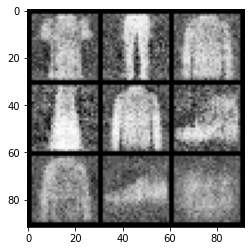

Epoch [    5/   50] | d_loss: 1.2238 | g_loss: 1.0892


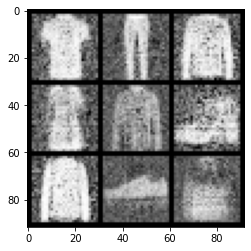

Epoch [   10/   50] | d_loss: 1.1727 | g_loss: 1.3595


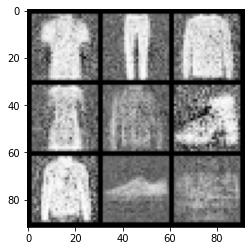

Epoch [   15/   50] | d_loss: 1.2633 | g_loss: 1.1137


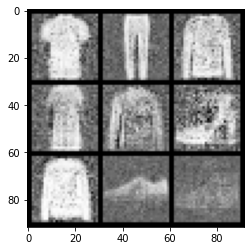

Epoch [   20/   50] | d_loss: 1.1794 | g_loss: 1.1900


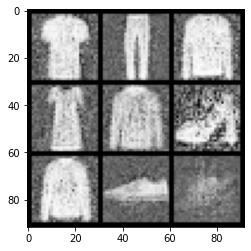

Epoch [   25/   50] | d_loss: 1.2089 | g_loss: 1.4447


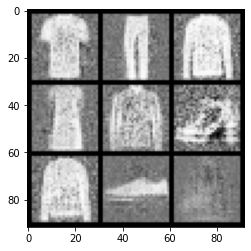

Epoch [   30/   50] | d_loss: 1.2972 | g_loss: 0.9430


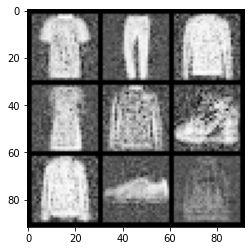

Epoch [   35/   50] | d_loss: 1.1421 | g_loss: 1.5356


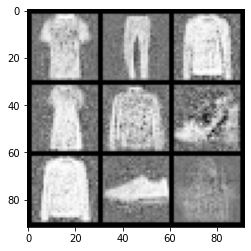

Epoch [   40/   50] | d_loss: 0.9713 | g_loss: 1.6686


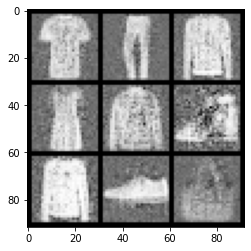

Epoch [   45/   50] | d_loss: 0.8088 | g_loss: 1.4726


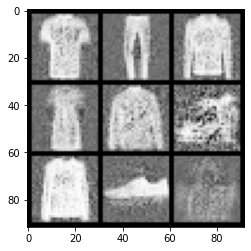

Epoch [   50/   50] | d_loss: 1.0042 | g_loss: 1.6640


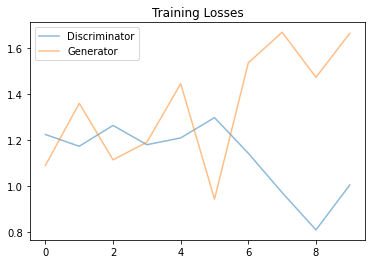

In [9]:
fixed_z = Variable(torch.randn(class_num-1, z_size)).to(device)
fixed_labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)
for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(train_loader):
                
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        G.train()
        # train discriminator         
        d_loss = discriminator_train_step(len(real_images), D,
                                          G, d_optimizer, criterion,
                                          real_images, labels)
        
        
        # train generator
        g_loss = generator_train_step(batch_size, D, G, g_optimizer, criterion)
        
        # train with fake images and flipped labels    
        G.eval()

    # printing the loss and the improvment of a fixed noise over the whole training every 5 epoches
    if (epoch+1) % print_every == 0:
      sample_images = G(fixed_z, fixed_labels).unsqueeze(1).data.cpu()

      # displaying images
      grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
      plt.imshow(grid)
      plt.show()

      # appending discriminator loss and generator loss
      losses.append((d_loss.item(), g_loss.item()))

      # printing discriminator and generator loss
      print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
              epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    


# saving training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

# plotting
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()


# helper function for displaying a list of sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

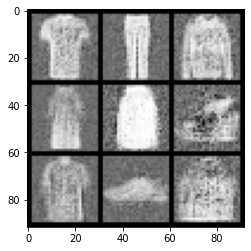

In [10]:
# noise 
noise = Variable(torch.randn(class_num-1, z_size)).to(device)

# labels
labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)

# sample_images
sample_images = G(noise, labels).unsqueeze(1).data.cpu()

# grid
grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()

# showing the grid images
plt.imshow(grid)
plt.show()

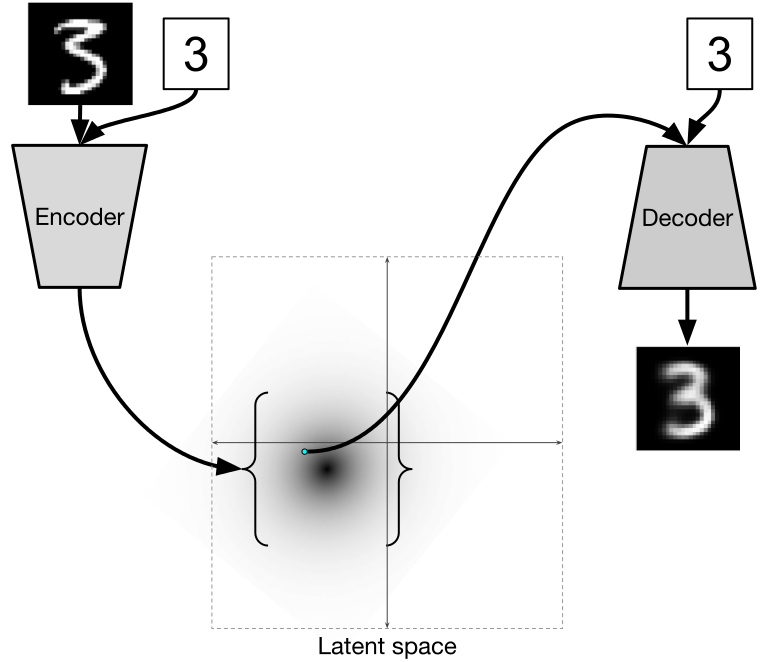

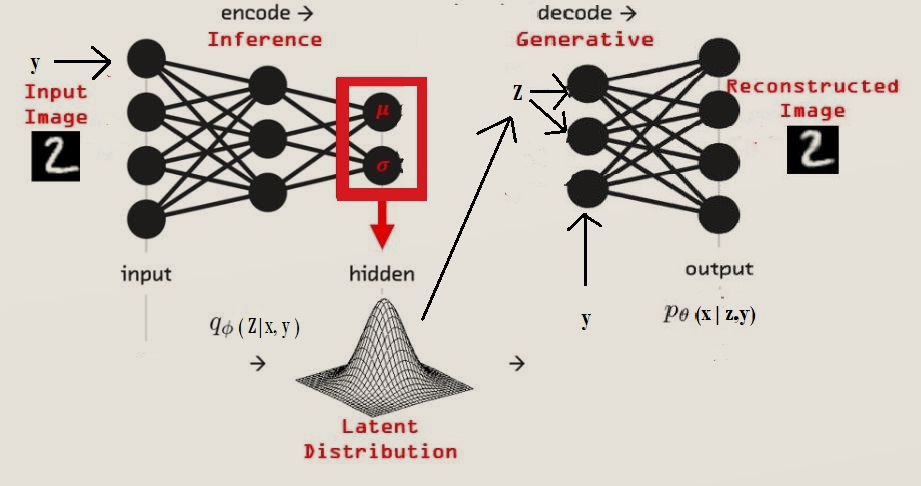

# Conditional Variational Autoencoder

Change this VAE implementation into Conditional VAE 

## Data

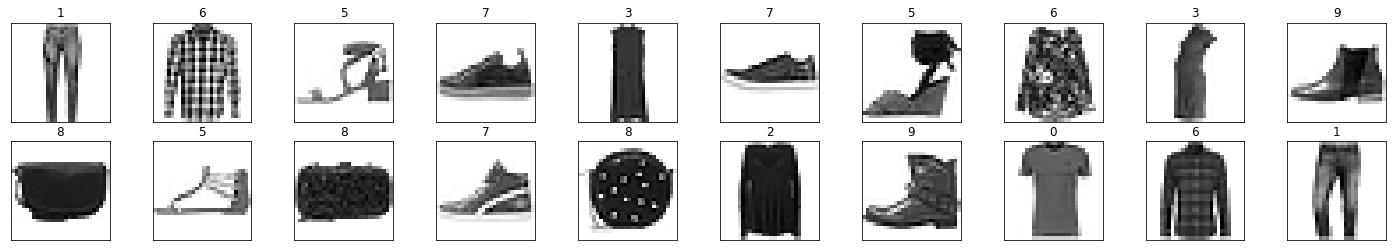

In [11]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from torchvision.utils import make_grid
from torch.autograd import Variable
import torch
from torchvision import datasets
from torchvision import transforms

# convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
transform = transforms.ToTensor()

# importing the dataset, same as in the previous step
#FMNIST_train = datasets.FashionMNIST(root='data/', train=True, download=True, transform=transform)
#FMNIST_test = datasets.FashionMNIST(root='data/', train=False, download=True, transform=transform)

# intializing batch size
batch_size = 128

# intializing num_workers
num_workers = 0

# building dataloader for our dataset
train_loader = torch.utils.data.DataLoader(dataset=FMNIST_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

# obtaining one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# ploting the images and labels in the batch
fig = plt.figure(figsize=(25, 4))
plot_size=20
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape(28,28), cmap='gray_r')
    ax.set_title(str(labels[idx].item()))


# current range
img = images[0]

## Encoder

In [12]:
# importing libraries
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import matplotlib
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# checking if GPU is available 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print yes if available 
print('Training on',DEVICE)

Training on cuda


In [15]:
# setting seed for reproducibility
SEED = 42

# numpy random seed
np.random.seed(SEED)

# torch manual seed
torch.manual_seed(SEED)

# cuda manual seed
torch.cuda.manual_seed(SEED)

# setting torch backend as true
torch.backends.cudnn.deterministic = True

# intializing batch size
batch_size = 128

# intializing learning rate
learning_rate = 0.005

# intializing input size
input_size = 28*28

# intializing hidden size
hidden_size = 12

# intializing length of labels
labels_length = 10

# transforming into a tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [16]:
# getting dataset 
dataset = FashionMNIST('./data', transform=transform, download=True)

# splitting into train, test and validation sets 
train_data, test_data = data.random_split(dataset, (50000,10000))
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [17]:
#helper functions

# Returns a 2-D tensor with ones on the diagonal and zeros elsewhere.
def one_hot(x, max_x):
    return torch.eye(max_x + 1)[x]

# plotting the results 
def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.axis("off")
        plt.imshow(images[i].reshape(h, w), cmap = matplotlib.cm.binary)
    plt.show()

# plotting loss    
def plot_loss(history):
    loss, val_loss = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [18]:
# class autoencoder, it has the architecture 
# refrence - https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size + labels_length, 64),
            #nn.ReLU(True),
            #nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, hidden_size))
             
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size + labels_length, 64),
            nn.ReLU(True),
            #nn.Linear(64, 128),
            #nn.ReLU(True),
            nn.Linear(64, input_size),
            nn.Tanh())

    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x,labels),dim=1)
        return self.encoder(x)
    
    def decode(self, x, labels):
        x = torch.cat((x,labels),dim=1)
        return self.decoder(x)

    def forward(self, x, labels):
        x = self.encode(x,labels)
        x = self.decode(x,labels)
        return x

In [19]:
# intialize model
model = autoencoder().to(DEVICE)

# using Mean squared error
criterion = nn.MSELoss()

# using adam optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
# function to fit and train the model and return training loss
def fit_epoch(model, train_loader, criterion, optimizer, is_cvae):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)
        optimizer.zero_grad()
        if is_cvae:
            outputs, mu, logvar = model(inputs,labels)
            loss = vae_loss_fn(inputs.view(-1,28*28), outputs, mu, logvar)
            loss.backward()
        else:
            outputs = model(inputs,labels)
            loss = criterion(outputs, inputs.view(-1,28*28))
            loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    return train_loss

# function to evaluate the model at every epoch using the validation set 
# it returns the validation loss
def eval_epoch(model, val_loader, criterion, is_cvae):
    model.eval()
    running_loss = 0.0
    processed_size = 0
    inp,out = [],[]
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        with torch.set_grad_enabled(False):
            if is_cvae:
                outputs, mu, logvar = model(inputs,labels)
                loss = vae_loss_fn(inputs.view(-1,28*28), outputs, mu, logvar)
                loss.backward()
            else:
                outputs = model(inputs,labels)
                loss = criterion(outputs, inputs.view(-1,28*28))
                inp,out = inputs, outputs

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)
        
    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].cpu(),out[0].cpu()],28,28,1,2)

    val_loss = running_loss / processed_size
    return val_loss

# function to save the history of train and val loss to plot the loss curve
def train(train_loader, val_loader, model, epochs, batch_size, is_cvae=False):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:        
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.MSELoss()
        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt, is_cvae)
            print("loss", train_loss)            
            val_loss = eval_epoch(model, val_loader, criterion, is_cvae)
            history.append((train_loss, val_loss))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))            
    return history

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 0.1405989128780365


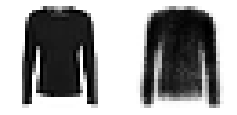

epoch:   2%|▏         | 1/50 [00:11<09:18, 11.40s/it]


Epoch 001 train_loss: 0.1406 val_loss 0.0853
loss 0.07814228100299835


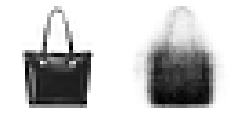

epoch:   4%|▍         | 2/50 [00:21<08:40, 10.83s/it]


Epoch 002 train_loss: 0.0781 val_loss 0.0746
loss 0.07190994990348816


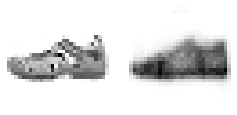

epoch:   6%|▌         | 3/50 [00:32<08:22, 10.68s/it]


Epoch 003 train_loss: 0.0719 val_loss 0.0708
loss 0.06881936636209487


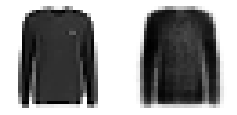

epoch:   8%|▊         | 4/50 [00:43<08:24, 10.97s/it]


Epoch 004 train_loss: 0.0688 val_loss 0.0682
loss 0.06670640909910203


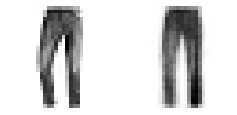

epoch:  10%|█         | 5/50 [00:54<08:13, 10.96s/it]


Epoch 005 train_loss: 0.0667 val_loss 0.0664
loss 0.06503346507787705


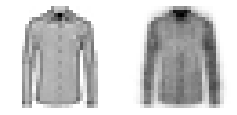

epoch:  12%|█▏        | 6/50 [01:05<08:03, 10.99s/it]


Epoch 006 train_loss: 0.0650 val_loss 0.0651
loss 0.06376962197542191


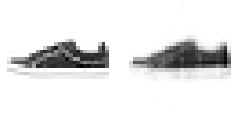

epoch:  14%|█▍        | 7/50 [01:16<07:51, 10.97s/it]


Epoch 007 train_loss: 0.0638 val_loss 0.0639
loss 0.06284482377290726


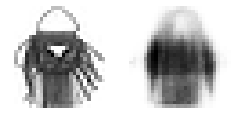

epoch:  16%|█▌        | 8/50 [01:27<07:36, 10.88s/it]


Epoch 008 train_loss: 0.0628 val_loss 0.0630
loss 0.062030465807914735


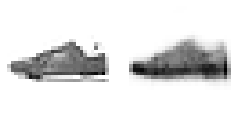

epoch:  18%|█▊        | 9/50 [01:38<07:23, 10.81s/it]


Epoch 009 train_loss: 0.0620 val_loss 0.0625
loss 0.06141469242572784


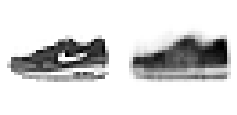

epoch:  20%|██        | 10/50 [01:48<07:10, 10.77s/it]


Epoch 010 train_loss: 0.0614 val_loss 0.0617
loss 0.06083396947979927


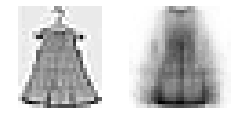

epoch:  22%|██▏       | 11/50 [02:00<07:06, 10.93s/it]


Epoch 011 train_loss: 0.0608 val_loss 0.0615
loss 0.06033373784065246


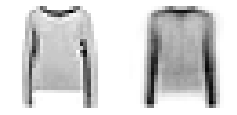

epoch:  24%|██▍       | 12/50 [02:10<06:53, 10.88s/it]


Epoch 012 train_loss: 0.0603 val_loss 0.0609
loss 0.059948571343421936


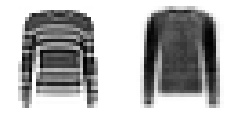

epoch:  26%|██▌       | 13/50 [02:21<06:39, 10.79s/it]


Epoch 013 train_loss: 0.0599 val_loss 0.0605
loss 0.05951243623137474


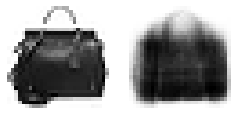

epoch:  28%|██▊       | 14/50 [02:32<06:27, 10.75s/it]


Epoch 014 train_loss: 0.0595 val_loss 0.0602
loss 0.05921619013547897


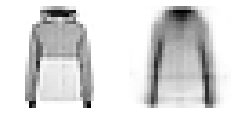

epoch:  30%|███       | 15/50 [02:42<06:15, 10.72s/it]


Epoch 015 train_loss: 0.0592 val_loss 0.0598
loss 0.05890547177433968


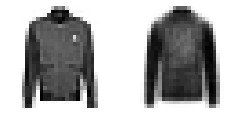

epoch:  32%|███▏      | 16/50 [02:53<06:02, 10.66s/it]


Epoch 016 train_loss: 0.0589 val_loss 0.0596
loss 0.058621150714159014


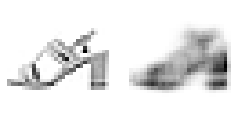

epoch:  34%|███▍      | 17/50 [03:03<05:49, 10.60s/it]


Epoch 017 train_loss: 0.0586 val_loss 0.0591
loss 0.05834251296043396


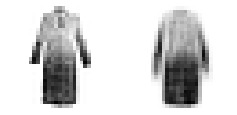

epoch:  36%|███▌      | 18/50 [03:14<05:39, 10.60s/it]


Epoch 018 train_loss: 0.0583 val_loss 0.0589
loss 0.05808388596296311


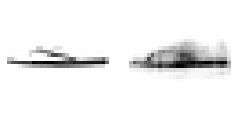

epoch:  38%|███▊      | 19/50 [03:24<05:27, 10.56s/it]


Epoch 019 train_loss: 0.0581 val_loss 0.0587
loss 0.05788547657608986


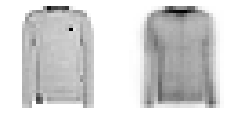

epoch:  40%|████      | 20/50 [03:35<05:16, 10.54s/it]


Epoch 020 train_loss: 0.0579 val_loss 0.0585
loss 0.05765194185614586


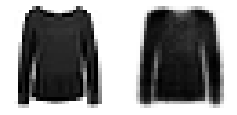

epoch:  42%|████▏     | 21/50 [03:45<05:04, 10.52s/it]


Epoch 021 train_loss: 0.0577 val_loss 0.0585
loss 0.05744302169084549


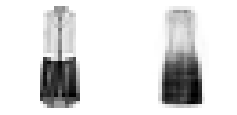

epoch:  44%|████▍     | 22/50 [03:56<04:54, 10.51s/it]


Epoch 022 train_loss: 0.0574 val_loss 0.0583
loss 0.05727429098367691


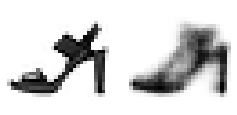

epoch:  46%|████▌     | 23/50 [04:06<04:42, 10.48s/it]


Epoch 023 train_loss: 0.0573 val_loss 0.0580
loss 0.05706680404663086


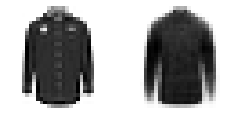

epoch:  48%|████▊     | 24/50 [04:17<04:37, 10.69s/it]


Epoch 024 train_loss: 0.0571 val_loss 0.0580
loss 0.05692833388209343


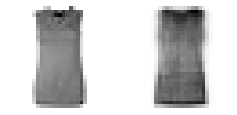

epoch:  50%|█████     | 25/50 [04:28<04:25, 10.63s/it]


Epoch 025 train_loss: 0.0569 val_loss 0.0576
loss 0.05675495602846146


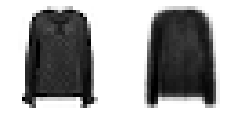

epoch:  52%|█████▏    | 26/50 [04:38<04:13, 10.58s/it]


Epoch 026 train_loss: 0.0568 val_loss 0.0574
loss 0.05660552835583687


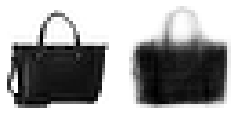

epoch:  54%|█████▍    | 27/50 [04:49<04:02, 10.52s/it]


Epoch 027 train_loss: 0.0566 val_loss 0.0575
loss 0.05648400182247162


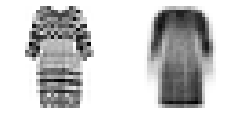

epoch:  56%|█████▌    | 28/50 [04:59<03:51, 10.50s/it]


Epoch 028 train_loss: 0.0565 val_loss 0.0575
loss 0.05634794350147247


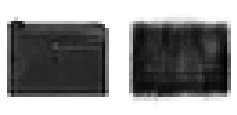

epoch:  58%|█████▊    | 29/50 [05:10<03:40, 10.52s/it]


Epoch 029 train_loss: 0.0563 val_loss 0.0572
loss 0.05617322885274887


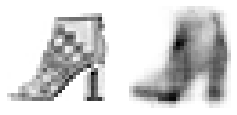

epoch:  60%|██████    | 30/50 [05:20<03:29, 10.48s/it]


Epoch 030 train_loss: 0.0562 val_loss 0.0570
loss 0.0560806148993969


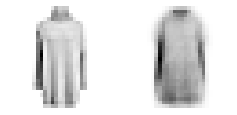

epoch:  62%|██████▏   | 31/50 [05:30<03:18, 10.46s/it]


Epoch 031 train_loss: 0.0561 val_loss 0.0569
loss 0.05595820618033409


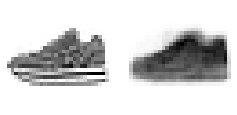

epoch:  64%|██████▍   | 32/50 [05:41<03:08, 10.45s/it]


Epoch 032 train_loss: 0.0560 val_loss 0.0570
loss 0.05583949942588806


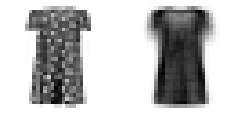

epoch:  66%|██████▌   | 33/50 [05:52<02:59, 10.56s/it]


Epoch 033 train_loss: 0.0558 val_loss 0.0567
loss 0.05576288615465164


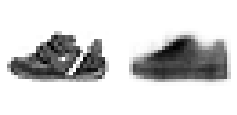

epoch:  68%|██████▊   | 34/50 [06:02<02:50, 10.64s/it]


Epoch 034 train_loss: 0.0558 val_loss 0.0566
loss 0.055661270425319674


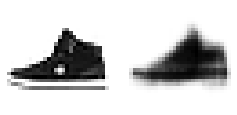

epoch:  70%|███████   | 35/50 [06:13<02:39, 10.66s/it]


Epoch 035 train_loss: 0.0557 val_loss 0.0567
loss 0.05552511490106583


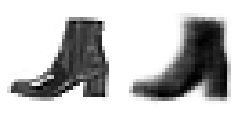

epoch:  72%|███████▏  | 36/50 [06:24<02:29, 10.65s/it]


Epoch 036 train_loss: 0.0555 val_loss 0.0564
loss 0.055452120563983916


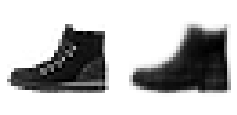

epoch:  74%|███████▍  | 37/50 [06:34<02:18, 10.64s/it]


Epoch 037 train_loss: 0.0555 val_loss 0.0563
loss 0.05537399468660355


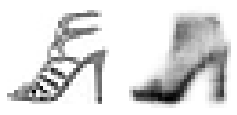

epoch:  76%|███████▌  | 38/50 [06:45<02:07, 10.62s/it]


Epoch 038 train_loss: 0.0554 val_loss 0.0564
loss 0.055318707513809205


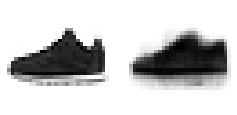

epoch:  78%|███████▊  | 39/50 [06:56<01:56, 10.62s/it]


Epoch 039 train_loss: 0.0553 val_loss 0.0562
loss 0.05520844292879105


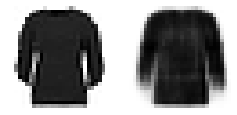

epoch:  80%|████████  | 40/50 [07:06<01:46, 10.64s/it]


Epoch 040 train_loss: 0.0552 val_loss 0.0563
loss 0.055119057956933976


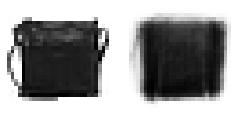

epoch:  82%|████████▏ | 41/50 [07:17<01:35, 10.64s/it]


Epoch 041 train_loss: 0.0551 val_loss 0.0561
loss 0.05505881338953972


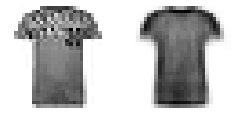

epoch:  84%|████████▍ | 42/50 [07:28<01:25, 10.65s/it]


Epoch 042 train_loss: 0.0551 val_loss 0.0561
loss 0.05500191952228546


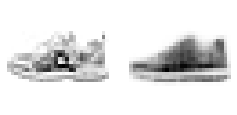

epoch:  86%|████████▌ | 43/50 [07:38<01:14, 10.62s/it]


Epoch 043 train_loss: 0.0550 val_loss 0.0559
loss 0.05490723651885986


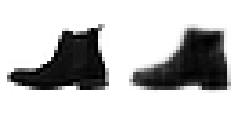

epoch:  88%|████████▊ | 44/50 [07:49<01:03, 10.61s/it]


Epoch 044 train_loss: 0.0549 val_loss 0.0559
loss 0.05485230336546898


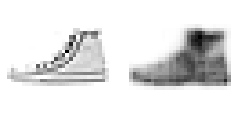

epoch:  90%|█████████ | 45/50 [07:59<00:52, 10.58s/it]


Epoch 045 train_loss: 0.0549 val_loss 0.0560
loss 0.05479696111321449


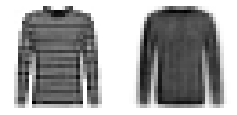

epoch:  92%|█████████▏| 46/50 [08:11<00:43, 10.79s/it]


Epoch 046 train_loss: 0.0548 val_loss 0.0557
loss 0.05474123444914818


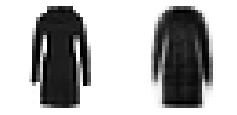

epoch:  94%|█████████▍| 47/50 [08:21<00:32, 10.71s/it]


Epoch 047 train_loss: 0.0547 val_loss 0.0558
loss 0.05467306459546089


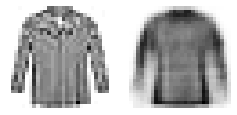

epoch:  96%|█████████▌| 48/50 [08:32<00:21, 10.66s/it]


Epoch 048 train_loss: 0.0547 val_loss 0.0557
loss 0.05459464834690094


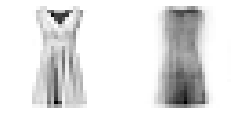

epoch:  98%|█████████▊| 49/50 [08:42<00:10, 10.61s/it]


Epoch 049 train_loss: 0.0546 val_loss 0.0556
loss 0.05452226863145828


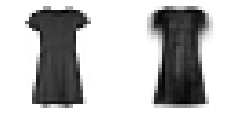

epoch: 100%|██████████| 50/50 [08:53<00:00, 10.66s/it]


Epoch 050 train_loss: 0.0545 val_loss 0.0557


In [21]:
# training model to 50 epochs and storing the history 
history = train(train_dataset, val_dataset, model=model, epochs=50, batch_size=128, is_cvae=False)

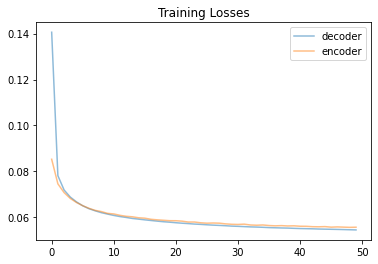

In [22]:
# plotting the training loss for encoder and decoder 
fig, ax = plt.subplots()
losses = np.array(history)
plt.plot(losses.T[0], label='decoder', alpha=0.5)
plt.plot(losses.T[1], label='encoder', alpha=0.5)
plt.title("Training Losses")
plt.legend()

# Comparison
Generate images of given labels using both Conditional GAN and Conditional VAE models that you trained. Write your opinion which model is better.

tensor([[4]])


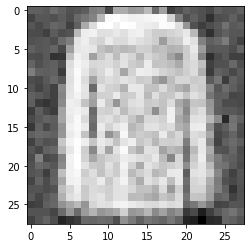

In [25]:
# generating GAN image 
label = 4
GAN_noise = Variable(torch.randn(1, z_size)).to(device)
print(torch.tensor([label]).reshape(1,1))
sample_image_GAN = G(GAN_noise, torch.tensor(label).reshape(1).to(device)).unsqueeze(1).data.cpu()
plt.imshow(sample_image_GAN.reshape(28, 28), cmap='gray')

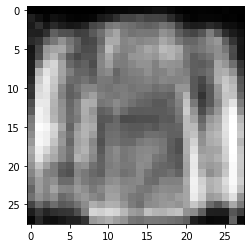

In [26]:
# generating encoder image
VAE_noise = torch.randn(1, 12).to(device)
VAE_label = one_hot(label,9).reshape(1,10).to(device)
new_image = model.decode(VAE_noise, VAE_label)
plt.imshow(new_image.reshape(28,28).cpu().detach().numpy(), cmap='gray')

**Conclusion**:
For the results it seems that the CGAN is producing more shaped and visible results.

Whereas the result of the CVAE don't seem to be clear and defintly can't compete with the CGAN

## Conditional GAN
Generate two images of each class from Fashion MNIST dataset using your Conditional GAN model

In [27]:
t = [i for i in range(10)]
for i in range(10):
  t.append(i)
print(torch.tensor(t))

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


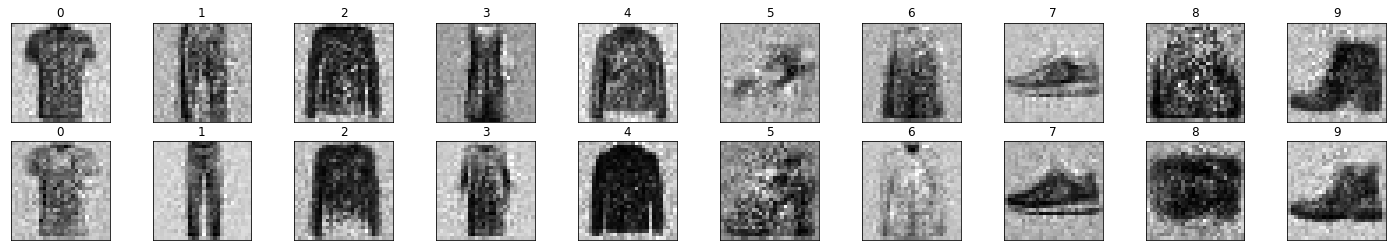

In [28]:
# generating conditional GAN
GAN_noise = Variable(torch.randn(20, z_size)).to(device)
images = G(GAN_noise, torch.tensor(t).to(device)).unsqueeze(1).data.cpu()
fig = plt.figure(figsize=(25, 4))
plot_size=20
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape(28,28), cmap='gray_r')
    ax.set_title(str(t[idx]))

## Conditional VAE
Generate two images of each class from Fashion MNIST dataset using your Conditional VAE model

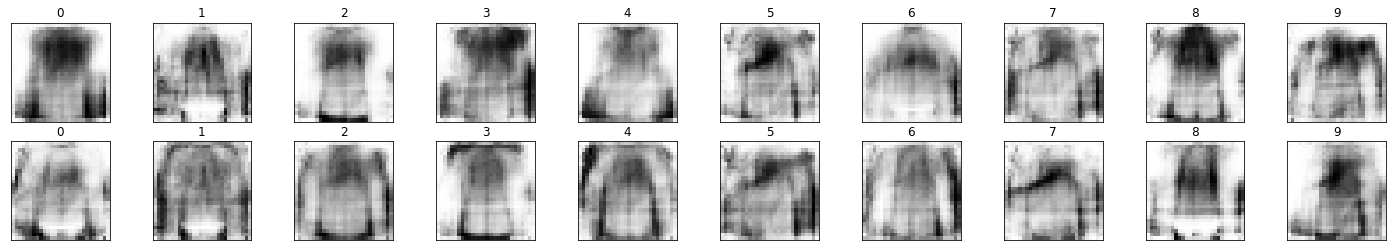

In [29]:
# generating conditional VAE
VAE_noise = torch.randn(20, 12).to(device)
VAE_label = one_hot(t,9).to(device)
images = model.decode(VAE_noise, VAE_label).cpu().detach().numpy()
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape(28,28), cmap='gray_r')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(t[idx]))

## My opinion

I think, after printing 20 images, we can clearly see that CGAN is superior in generating clearer images. 

These generated images closely represent the training dataset

# References

* [Synthetic Data Generation Using Conditional-GAN](https://towardsdatascience.com/synthetic-data-generation-using-conditional-gan-45f91542ec6b)

* [Generating synthetic tabular data with GANs](https://medium.com/ydata-ai/generating-synthetic-tabular-data-with-gans-part-2-a0aba150539)

* [Understanding Conditional Variational Autoencoders](https://theaiacademy.blogspot.com/2020/05/understanding-conditional-variational.html)

* [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

* [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)

* [Tutorial - What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

* [The variational auto-encoder](https://ermongroup.github.io/cs228-notes/extras/vae/)

* [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691)

* [Basic VAE Example](https://github.com/pytorch/examples/tree/master/vae)

* [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan)

* [Generative adversarial networks: What GANs are and how they’ve evolved](https://venturebeat.com/2019/12/26/gan-generative-adversarial-network-explainer-ai-machine-learning/)

* [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

* [GANs by google](https://developers.google.com/machine-learning/gan)

* [A Gentle Introduction to Generative Adversarial Networks (GANs)](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

* [A Beginner's Guide to Generative Adversarial Networks (GANs)](https://pathmind.com/wiki/generative-adversarial-network-gan)

* [Understanding Generative Adversarial Networks (GANs)](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)

* [Deep Learning (PyTorch)](https://github.com/udacity/deep-learning-v2-pytorch)

* [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)

* [GAN(Generative Adversarial Networks) и tensorflow (Russian)](https://habr.com/ru/post/332000/)

* [Conditional VAE (Russian)](https://habr.com/ru/post/331664/)